# Oversampling to create spurious relationship

In general, most oversampling strategies assume some relationship between the features and the target. For example, SMOTE assumes that it can generate new samples by linearly interpolating between existing minority samples. This **creates** a relationship between the features and the target, even if there is none.

This does not mean that SMOTE is bad, it just means that you have to be careful with it &mdash; and with all oversampling strategies. Some suggestions for best practice:

- Know exactly what it does.
- Check the difference that oversampling makes.
- Consider simple strategies like fuzzing, eg Gaussian noise up-sampling, at least for comparison.
- Only ever apply data augmentation *after* splitting out validation and test sets. Be aware that this means you have to be very careful if applying folded cross-validation, for example as part of a hyperparameter tuning step.

## Make a dataset

This highly imbalanced dataset is random and contains no predictable relationships.

In [1]:
import numpy as np

rng = np.random.default_rng(42)

# The higher these numbers, the clearer the problem.
N = 10_000   # Number of samples.
M = 5        # Number of features.

X = rng.uniform(size=(N, M))
y = rng.binomial(n=1, p=0.1, size=N)

## Fit and score a classifier

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's try a random forest...

In [3]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8984

Other models perform similarly.

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8988

Looks amazing... remember how imbalanced the dataset is!

The ROC-AUC will not be fooled:

In [5]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

0.5131426882747484

And the `DummyClassifier`, whose default strategy will simply pick the majority class, makes it obvious that our model is bad.

In [6]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.8988

## Now with oversampling

We will first oversample BEFORE splitting.

In [7]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

This (binary) dataset is now balanced, so the dummy classifier scores about 50%.

In [9]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.4956599154239929

Now with a random forest:

In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8762519474738482

In [11]:
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

0.9468475632641365

Wow! Amazing.

Logistic regression behaves as before:

In [127]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5376106194690266

In [128]:
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

0.5497082915905475

## Oversampling after split

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [142]:
dummy = DummyClassifier()
dummy.fit(X_res, y_res)
dummy.score(X_test, y_test)

0.928

In [143]:
model = RandomForestClassifier()
model.fit(X_res, y_res)
model.score(X_test, y_test)

0.648

In [144]:
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

0.459889846743295

This is back to the 50/50 score we saw before.

## Why?

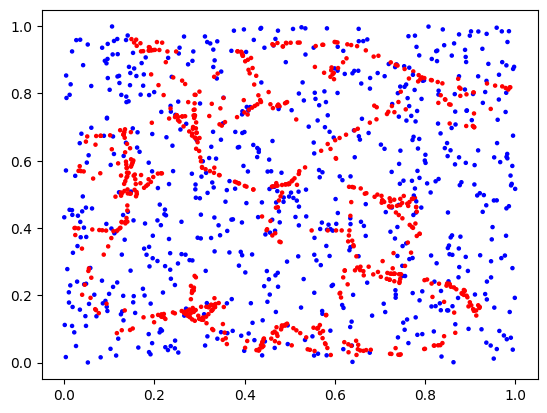

In [145]:
import matplotlib.pyplot as plt

plt.scatter(*X_res.T, c=y_res, s=5, cmap='bwr')

## Open questions

- Should you over or undersample before or after scaling? Let's check if SMOTE changes mean or stdev. E.g. see this paper and probably lots of others: https://www.sciencedirect.com/science/article/pii/S1568494622009024 and https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/. Intuitively, I think it's safer to scale first, because then the scaler only gets to see real data.